In [18]:
import zipfile
import json
import pandas as pd
from tqdm import tqdm
from os.path import exists
### nltk sutff
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk


In [19]:
# https://www.kaggle.com/balraj98/movie-genre-prediction-from-wiki-plot-using-bert
def get_wiki_data():
    if not exists('wiki_movie_plots_deduped.csv'):
        with zipfile.ZipFile('wiki_movie_plots_deduped.csv.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
    plots = pd.read_csv('wiki_movie_plots_deduped.csv')
    wiki = plots.drop(columns=['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'])
    wiki = wiki[['Title', 'Plot', 'Genre']]
    return wiki


In [20]:
# https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags
def get_mpst_data():
    if not exists('mpst_full_data.csv'):
        with zipfile.ZipFile('mpst-movie-plot-synopses-with-tags.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
    plots_mpst = pd.read_csv('mpst_full_data.csv')
    mpst = plots_mpst.drop(columns=['imdb_id', 'split','synopsis_source'])
    mpst = mpst.rename(columns={'title':'Title', 'plot_synopsis': 'Plot','tags':'Genre'})
    mpst.head()
    return mpst


In [21]:
# Парсинг json с описанием жанра и преобразование в список жанров, разделенных запятой
def get_genres_as_list(input: str):
    input = input.replace('\'','"')
    json_s = json.loads(input)
    t = []
    for a in json_s:
        t.append(a['name'])
    res = ', '.join(t)
    return res

# https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
def get_movies_dataset_data():
    if not exists('movies_metadata.csv'):
        with zipfile.ZipFile('movies_metadata.csv.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
    current_dataset = pd.read_csv('movies_metadata.csv')
    current_dataset = current_dataset.drop(columns=['adult', 'belongs_to_collection', 'budget', 'homepage','id', 'imdb_id','original_language', 'video', 'vote_average', 'vote_count', 'status', 'spoken_languages', 'runtime','revenue', 'release_date', 'production_countries', 'production_companies', 'original_title' ,'poster_path', 'tagline','popularity'])
    current_dataset['Genre'] = current_dataset['genres'].apply(get_genres_as_list )
    current_dataset.drop(columns='genres')
    current_dataset = current_dataset.rename(columns={'title':'Title', 'overview': 'Plot'})
    current_dataset = current_dataset[['Title', 'Plot', 'Genre']]
    return current_dataset

In [22]:
mpst = get_mpst_data()
wiki = get_wiki_data()
movies = get_movies_dataset_data()
merged_dataset = pd.concat([mpst, wiki,movies])
print(merged_dataset.shape)
merged_dataset.head()

(95180, 3)


/var/folders/52/g94rqcwd0r55zsr1ccm405300000gp/T/ipykernel_34205/3916261343.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  current_dataset = pd.read_csv('movies_metadata.csv')


,Title,Plot,Genre
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric"
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good"
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm..."


In [23]:
unique_genres_count = merged_dataset['Genre'].unique().shape[0]
print(f'Уникальных значений в поле жанр: {unique_genres_count}')

Уникальных значений в поле жанр: 11914


In [24]:
merged_dataset = merged_dataset.dropna()
tokenizer = WordPunctTokenizer()
all_words = list()
exception_count = 0
for a, t in tqdm(merged_dataset.iterrows()):
    try:
        for cc in tokenizer.tokenize(t['Plot']):
            all_words.append(cc)
    except:
        exception_count+=1
        print(t['Plot'])
len_total_words_without_processing = len(all_words)
print(f'Общее количество уникальны слов без лемматизации и стемминга: {len_total_words_without_processing}, исключений: {exception_count}')


94220it [00:10, 9324.99it/s] 

Общее количество уникальны слов без лемматизации и стемминга: 33821695, исключений: 0


In [25]:
lem = WordNetLemmatizer()
stem = PorterStemmer()

def process_plot(plot: str):
    tokenized_plot = tokenizer.tokenize(plot)
    processed = []
    for a in tokenized_plot:
        w1 = stem.stem(lem.lemmatize(a))
        processed.append(w1)
    res = ' '.join(processed)
    return res

merged_dataset['Processed plot'] = merged_dataset['Plot'].apply(process_plot)
merged_dataset.head()

,Title,Plot,Genre,Processed plot
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",note : thi synopsi is for the orgin italian re...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,"two thousand year ago , nhagruul the foul , a ..."
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,"matuschek ' s , a gift store in budapest , is ..."
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good","glenn holland , not a morn person by anyon ' s..."
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...","in may 1980 , a cuban man name toni montana ( ..."


In [26]:
merged_dataset.to_csv('merged_dataset.csv')

In [27]:
def get_sentiment(obj: tuple):
    neg = obj['neg']
    neu = obj['neu']
    pos = obj['pos']
    if neg > neu:
        if neg > pos:
            return 'neg'
        else:
            return 'pos'
    else:
        if neu > pos:
            return 'neu'
        else:
            return 'pos'

nltk.downloader.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sentiments = list()
limit = 1000
current_iteration = 0
for a, t in tqdm(merged_dataset.iterrows()):
    current_result = get_sentiment(sia.polarity_scores(t['Processed plot']))
    sentiments.append(current_result)
    current_iteration+=1
negatives_count = sentiments.count('neg')
postigive_count = sentiments.count('pos')
neutral_count   = sentiments.count('neu')
print(f'Статистика по polarity_score на сырых данных сюжета: negative: {negatives_count}, positive: {postigive_count}, neutral: {neutral_count}')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/max/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
94220it [02:41, 583.27it/s] 

Статистика по polarity_score на сырых данных сюжета: negative: 215, positive: 35, neutral: 93970


Статистика по polarity_score на сырых данных сюжета: negative: 283, positive: 78, neutral: 93859 - результаты на необработанном Plot

<AxesSubplot:title={'center':'Количество фильмов с разным sentiment'}, xlabel='Sentiment'>

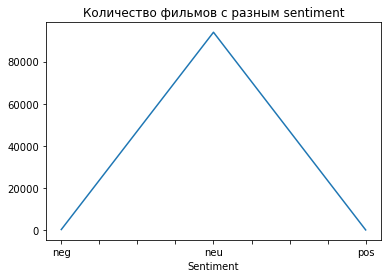

In [28]:
merged_dataset['Sentiment'] = sentiments
merged_dataset.head()
films_count_by_year = merged_dataset.groupby(['Sentiment'])['Title'].count()
films_count_by_year.plot(title = 'Количество фильмов с разным sentiment')
